In [7]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, \
    classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
import itertools
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.model_selection import cross_val_score
import seaborn as sn
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, ParameterGrid
import time
from sklearn.metrics import make_scorer, accuracy_score
from catboost import CatBoostClassifier, Pool
from tqdm import tqdm
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, \
    ExtraTreesClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.externals import joblib

In [10]:
data = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')

In [11]:
data = data.drop(columns=['ID'])
# Retrieve data from the train set
X = data[:10000].drop(columns=['DEFCON_Level'])
# Retrieve label from train set
y = data[:10000].DEFCON_Level
# Retrieve data from test set
#X_test = data[10000:].drop(columns=['DEFCON_Level'])
# split train file into train set (0.75) and valid set (0.25). The valid set is used to evaluate the model on the train set
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42)

In [12]:
def feature_extract():
    X['Closest_Threat_Distance(km)'] = X['Closest_Threat_Distance(km)'] / 1.06
    X['Troops_Mobilized(thousands)'] = X['Troops_Mobilized(thousands)'] / 100
    values = X['Troops_Mobilized(thousands)'].values.tolist()
    for idx in range(len(values)):
        if ".3" in str(values[idx]):
            values[idx] = round(values[idx] * 3) / 44
        elif ".6" in str(values[idx]):
            values[idx] = round(values[idx] * 3 / 2) / 44
    X['Troops_Mobilized(thousands)'] = values
    X['Percent_Of_Forces_Mobilized'] = X['Percent_Of_Forces_Mobilized'] / 0.01
    X['Closest_Threat_Distance(km)'] = X['Closest_Threat_Distance(km)'] / 1.06
feature_extract()

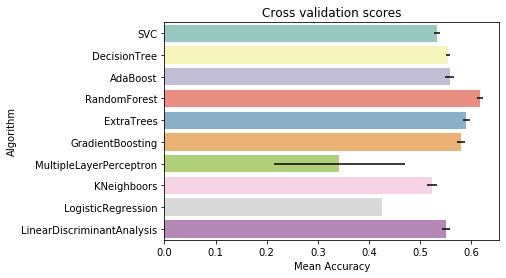

In [13]:
def compare_tree_based_models():
    random_state = 2
    classifiers = [SVC(random_state=random_state), DecisionTreeClassifier(random_state=random_state),
                   AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state), random_state=random_state,
                                      learning_rate=0.1), RandomForestClassifier(random_state=random_state),
                   ExtraTreesClassifier(random_state=random_state),
                   GradientBoostingClassifier(random_state=random_state), MLPClassifier(random_state=random_state),
                   KNeighborsClassifier(), LogisticRegression(random_state=random_state), LinearDiscriminantAnalysis()]

    cv_results = []
    for classifier in classifiers:
        cv_results.append(cross_val_score(classifier, X_train, y=y_train, scoring="accuracy", cv=4, n_jobs=4))

    cv_means = []
    cv_std = []
    for cv_result in cv_results:
        cv_means.append(cv_result.mean())
        cv_std.append(cv_result.std())

    cv_res = pd.DataFrame(
        {"CrossValMeans": cv_means, "CrossValerrors": cv_std, "Algorithm": ["SVC", "DecisionTree", "AdaBoost",
                                                                            "RandomForest", "ExtraTrees",
                                                                            "GradientBoosting",
                                                                            "MultipleLayerPerceptron", "KNeighboors",
                                                                            "LogisticRegression",
                                                                            "LinearDiscriminantAnalysis"]})

    g = sns.barplot("CrossValMeans", "Algorithm", data=cv_res, palette="Set3", orient="h", **{'xerr': cv_std})
    g.set_xlabel("Mean Accuracy")
    g = g.set_title("Cross validation scores")
    plt.show()

compare_tree_based_models()


In [14]:
scaler_minmax = MinMaxScaler()
scaler_standard = StandardScaler()
# params for decision tree classifier
dt_param = {"base_estimator__criterion": ["gini", "entropy"],
            "base_estimator__max_depth": list(range(2, 10, 1)),
            'base_estimator__random_state': [21],
            'base_estimator__max_features': [10],
            "base_estimator__min_samples_leaf": list(range(5, 10, 5)),
            'base_estimator__min_samples_split': list(range(5, 10, 5)),
            'base_estimator__min_impurity_decrease': [0.00005, 0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01,
                                                      0.05, 0.1]}
max_score = 0
# use Kfold
sss = StratifiedKFold(n_splits=4, random_state=None, shuffle=False)
for train_index, val_index in sss.split(X, y):
    start_time = time.time()
    print("Train:", train_index, "Val:", val_index)
    X_train, X_valid = X.iloc[train_index], X.iloc[val_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[val_index]
    # standardized data
    X_train = scaler_standard.fit_transform(X_train)
    X_valid = scaler_standard.fit_transform(X_valid)
    # Use BaggingClassifier 
    model = BaggingClassifier(base_estimator=DecisionTreeClassifier(), oob_score=True, random_state=42)
    # Use GridSearchCV
    model = GridSearchCV(estimator=model, param_grid=dt_param, cv=4, verbose=3)
    model.fit(X_train, y_train)
    print(model.best_score_, model.best_params_)
    # # tree best estimator
    model = model.best_estimator_
    # Save the best params after training
    joblib.dump(model, 'DecisionTreeClassifier.pkl')
    # Evaluate the model with a valid set
    tree_score = cross_val_score(model, X_valid, y_valid, cv=4)
    print('Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')
    print("time execution :", time.time() - start_time)

Train: [2330 2344 2347 ... 9997 9998 9999] Val: [   0    1    2 ... 2866 2920 2953]
Fitting 4 folds for each of 160 candidates, totalling 640 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.536, total=   0.1s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.536, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.536, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.536, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.536, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.536, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.536, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.543, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.536, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.543, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.536, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.552, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.562, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.543, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.558, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.552, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.562, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.543, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.558, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.552, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.562, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.543, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.558, total=   0.3s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.552, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.562, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.543, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.558, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.552, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.562, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.543, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.558, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.552, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.562, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.543, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.558, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.554, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.536, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.551, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.543, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.536, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.543, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.536, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.573, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.564, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.547, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.564, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.573, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.564, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.547, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.564, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.573, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.564, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.547, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.564, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.573, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.564, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.547, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.564, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.573, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.564, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.547, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.564, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.564, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.559, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.565, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.554, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.536, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.551, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.543, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.536, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.543, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.536, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.579, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.594, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.564, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.596, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.579, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.594, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.564, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.596, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.579, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.594, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.564, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.596, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.580, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.594, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.564, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.596, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.579, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.592, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.564, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.597, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.569, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.570, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.554, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.585, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.554, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.536, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.551, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.543, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.536, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.543, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.536, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.585, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.601, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.588, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.611, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.585, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.601, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.588, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.611, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.586, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.601, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.588, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.611, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.587, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.599, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.586, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.612, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.585, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.596, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.581, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.607, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.577, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.572, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.559, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.588, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.554, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.536, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.551, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.543, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.536, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.543, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.536, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.610, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.605, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.598, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.625, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.609, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.605, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.597, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.625, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.611, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.605, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.597, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.626, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.611, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.605, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.598, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.626, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.602, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.611, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.589, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.614, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.579, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.572, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.563, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.589, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.554, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.536, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.551, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.543, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.536, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.543, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.536, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.614, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.618, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.597, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.638, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.614, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.618, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.598, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.639, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.612, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.617, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.598, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.638, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.617, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.623, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.596, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.635, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.607, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.611, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.587, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.624, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.581, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.572, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.563, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.589, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.554, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.536, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.551, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.543, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.536, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.543, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.536, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.617, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.621, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.605, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.645, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.616, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.622, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.606, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.645, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.619, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.621, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.607, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.641, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.619, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.625, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.608, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.641, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.611, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.616, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.596, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.638, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.581, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.572, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.563, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.589, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.554, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.536, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.551, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.543, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.536, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.543, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.536, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.543, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.536, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.543, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.536, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.543, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.536, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.543, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.536, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.543, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.536, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.543, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.536, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.543, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.536, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.543, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.536, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.543, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.543, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.558, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.549, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.550, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.558, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.549, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.550, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.558, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.549, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.550, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.558, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.549, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.550, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.558, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.549, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.550, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.558, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.549, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.550, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.558, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.549, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.550, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.558, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.549, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.550, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.543, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.543, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.576, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.561, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.565, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.561, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.576, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.561, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.565, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.561, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.576, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.561, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.565, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.561, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.576, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.561, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.565, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.561, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.576, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.561, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.565, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.561, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.576, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.561, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.565, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.561, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.574, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.558, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.555, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.561, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.560, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.549, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.548, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.550, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.543, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.543, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.585, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.581, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.571, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.588, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.585, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.581, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.571, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.588, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.585, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.581, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.571, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.588, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.585, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.581, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.571, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.588, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.585, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.581, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.571, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.589, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.584, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.581, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.572, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.589, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.579, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.575, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.569, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.589, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.560, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.549, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.550, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.555, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.543, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.543, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.602, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.605, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.600, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.606, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.602, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.605, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.600, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.606, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.602, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.605, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.600, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.606, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.603, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.606, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.600, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.606, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.603, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.604, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.600, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.604, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.605, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.606, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.601, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.604, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.601, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.581, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.583, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.599, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.560, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.549, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.550, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.555, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.543, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.543, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.595, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.614, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.606, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.622, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.595, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.614, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.606, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.622, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.595, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.614, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.606, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.622, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.597, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.614, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.606, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.621, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.598, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.614, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.607, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.621, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.599, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.614, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.604, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.619, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.603, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.585, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.599, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.604, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.560, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.549, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.550, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.555, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.543, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.543, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.602, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.615, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.625, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.642, total=   0.3s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.603, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.615, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.625, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.642, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.603, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.615, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.625, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.642, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.605, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.617, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.625, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.641, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.607, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.617, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.622, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.637, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.606, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.624, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.620, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.641, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.606, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.583, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.601, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.605, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.560, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.549, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.550, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.555, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.543, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.543, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.628, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.624, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.621, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.638, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.628, total=   0.3s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.624, total=   0.3s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.621, total=   0.3s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.638, total=   0.3s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.628, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.624, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.621, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.638, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.630, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.626, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.620, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.637, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.626, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.618, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.625, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.642, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.626, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.631, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.621, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.644, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.611, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.587, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.602, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.606, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.560, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.549, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.550, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.555, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.543, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.543, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s


[Parallel(n_jobs=1)]: Done 640 out of 640 | elapsed:  1.2min finished
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


0.6305333333333334 {'base_estimator__criterion': 'entropy', 'base_estimator__max_depth': 9, 'base_estimator__max_features': 10, 'base_estimator__min_impurity_decrease': 0.002, 'base_estimator__min_samples_leaf': 5, 'base_estimator__min_samples_split': 5, 'base_estimator__random_state': 21}


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. Th

Classifier Cross Validation Score 59.68%
time execution : 73.84787654876709
Train: [   0    1    2 ... 9997 9998 9999] Val: [2330 2344 2347 ... 5377 5379 5396]
Fitting 4 folds for each of 160 candidates, totalling 640 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.538, total=   0.1s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.538, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.538, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.538, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.538, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.538, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.538, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.538, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.519, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.538, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.561, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.563, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.540, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.567, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.561, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.563, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.540, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.567, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.561, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.563, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.540, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.567, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.561, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.563, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.540, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.567, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.561, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.563, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.540, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.567, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.561, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.563, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.540, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.567, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.538, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.536, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.538, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.519, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.538, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.570, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.562, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.555, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.585, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.570, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.562, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.555, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.585, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.570, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.562, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.555, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.585, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.570, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.562, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.555, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.585, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.570, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.562, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.555, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.585, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.568, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.561, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.555, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.585, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.538, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.536, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.538, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.519, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.538, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.576, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.580, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.566, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.598, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.576, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.580, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.566, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.598, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.576, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.580, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.566, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.598, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.577, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.580, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.566, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.598, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.576, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.579, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.566, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.598, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.574, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.575, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.558, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.593, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.538, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.536, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.538, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.519, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.538, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.582, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.590, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.584, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.609, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.582, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.590, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.584, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.609, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.582, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.590, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.584, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.608, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.581, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.590, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.581, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.609, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.582, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.592, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.580, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.613, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.582, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.583, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.566, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.594, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.538, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.536, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.538, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.519, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.538, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.606, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.605, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.588, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.624, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.606, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.605, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.588, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.623, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.605, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.604, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.588, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.624, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.605, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.604, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.589, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.623, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.591, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.605, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.588, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.626, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.584, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.588, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.566, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.593, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.538, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.536, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.538, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.519, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.538, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.624, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.614, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.605, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.635, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.624, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.612, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.605, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.634, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.623, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.615, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.604, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.635, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.623, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.615, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.606, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.630, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.611, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.608, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.602, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.625, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.595, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.590, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.568, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.593, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.538, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.536, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.538, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.519, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.538, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.626, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.613, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.613, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.641, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.628, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.614, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.615, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.641, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.630, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.616, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.613, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.638, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.625, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.615, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.610, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.639, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.604, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.610, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.607, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.625, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.598, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.589, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.567, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.593, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.538, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.536, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.538, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.519, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.538, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.539, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.539, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.539, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.539, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.539, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.539, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.539, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.539, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.520, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.531, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.520, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.531, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.551, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.558, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.539, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.564, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.551, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.558, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.539, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.564, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.551, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.558, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.539, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.564, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.551, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.558, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.539, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.564, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.551, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.558, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.539, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.564, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.551, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.558, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.539, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.564, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.551, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.558, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.539, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.564, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.551, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.550, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.539, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.564, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.520, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.531, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.520, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.531, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.571, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.565, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.555, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.583, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.571, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.565, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.555, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.583, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.571, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.565, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.555, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.583, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.571, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.565, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.555, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.583, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.571, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.565, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.555, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.583, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.571, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.565, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.555, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.583, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.571, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.566, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.554, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.579, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.554, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.551, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.549, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.572, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.520, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.531, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.520, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.531, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.589, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.581, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.570, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.607, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.589, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.581, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.570, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.607, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.589, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.581, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.570, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.607, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.589, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.581, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.570, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.607, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.589, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.581, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.570, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.607, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.590, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.581, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.570, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.607, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.585, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.575, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.570, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.601, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.558, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.551, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.550, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.572, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.520, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.531, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.520, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.531, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.606, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.602, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.589, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.617, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.606, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.602, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.589, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.617, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.606, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.602, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.589, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.617, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.607, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.602, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.589, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.617, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.607, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.603, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.586, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.616, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.608, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.597, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.588, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.619, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.592, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.587, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.587, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.606, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.557, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.551, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.550, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.572, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.520, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.531, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.520, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.531, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.619, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.608, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.610, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.631, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.619, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.608, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.610, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.631, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.619, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.608, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.610, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.631, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.618, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.608, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.610, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.632, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.617, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.608, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.611, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.634, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.618, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.609, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.610, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.641, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.590, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.587, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.597, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.606, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.557, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.551, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.550, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.572, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.520, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.531, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.520, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.531, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.644, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.621, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.615, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.645, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.644, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.621, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.615, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.645, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.644, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.621, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.615, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.645, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.645, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.622, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.617, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.647, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.647, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.620, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.618, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.649, total=   0.3s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.642, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.626, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.617, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.652, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.594, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.602, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.601, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.607, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.557, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.551, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.550, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.572, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.520, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.531, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.520, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.531, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.644, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.626, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.626, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.647, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.644, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.626, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.626, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.647, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.644, total=   0.3s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.626, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.626, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.647, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.645, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.625, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.626, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.645, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.646, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.627, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.630, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.647, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.641, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.629, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.619, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.653, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.593, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.604, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.601, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.607, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.557, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.551, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.550, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.572, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.520, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.531, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.520, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.531, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s


[Parallel(n_jobs=1)]: Done 640 out of 640 | elapsed:  1.1min finished
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


0.6376 {'base_estimator__criterion': 'entropy', 'base_estimator__max_depth': 9, 'base_estimator__max_features': 10, 'base_estimator__min_impurity_decrease': 0.001, 'base_estimator__min_samples_leaf': 5, 'base_estimator__min_samples_split': 5, 'base_estimator__random_state': 21}


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. Th

Classifier Cross Validation Score 58.04%
time execution : 67.41550874710083
Train: [   0    1    2 ... 9997 9998 9999] Val: [4935 4936 4937 ... 7719 7734 7737]
Fitting 4 folds for each of 160 candidates, totalling 640 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.540, total=   0.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.544, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.540, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.544, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.540, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.544, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.540, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.544, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.540, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.544, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.540, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.544, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.540, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.544, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.540, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.544, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.544, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.556, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.574, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.565, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.556, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.574, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.565, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.556, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.574, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.565, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.556, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.574, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.565, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.556, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.574, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.565, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.556, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.574, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.565, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.556, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.552, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.541, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.540, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.544, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.544, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.582, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.577, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.561, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.585, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.582, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.577, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.561, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.585, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.582, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.577, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.561, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.585, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.582, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.577, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.561, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.585, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.582, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.577, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.561, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.585, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.572, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.575, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.560, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.587, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.556, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.552, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.541, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.540, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.544, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.544, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.588, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.595, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.579, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.605, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.588, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.595, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.579, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.605, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.588, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.595, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.579, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.605, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.589, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.596, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.579, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.605, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.587, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.595, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.578, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.605, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.589, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.596, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.566, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.593, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.556, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.552, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.541, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.540, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.544, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.544, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.603, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.592, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.588, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.626, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.603, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.592, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.588, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.626, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.603, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.593, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.588, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.625, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.602, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.594, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.588, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.627, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.605, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.595, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.595, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.629, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.595, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.594, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.567, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.598, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.556, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.552, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.541, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.540, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.544, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.544, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.618, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.607, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.606, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.632, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.618, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.607, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.606, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.632, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.618, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.607, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.607, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.633, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.617, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.608, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.609, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.629, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.618, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.605, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.611, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.634, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.598, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.599, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.567, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.597, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.556, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.552, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.541, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.540, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.544, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.544, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.626, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.626, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.607, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.633, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.626, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.626, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.606, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.634, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.626, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.626, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.609, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.634, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.626, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.623, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.609, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.634, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.616, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.617, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.609, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.639, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.603, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.603, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.566, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.606, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.556, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.552, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.541, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.540, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.544, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.544, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.619, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.630, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.609, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.623, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.615, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.630, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.610, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.621, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.617, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.629, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.606, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.625, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.622, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.630, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.609, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.626, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.617, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.619, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.613, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.638, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.603, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.603, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.569, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.606, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.556, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.552, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.541, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.540, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.544, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.544, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.543, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.543, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.543, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.543, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.543, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.543, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.543, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.543, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.519, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.539, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.543, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.519, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.539, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.543, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.558, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.561, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.564, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.558, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.561, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.564, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.558, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.561, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.564, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.558, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.561, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.564, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.558, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.561, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.564, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.558, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.561, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.564, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.558, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.561, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.564, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.555, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.561, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.564, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.519, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.539, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.543, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.519, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.539, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.543, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.583, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.572, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.554, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.579, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.583, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.572, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.554, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.579, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.583, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.572, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.554, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.579, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.583, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.572, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.554, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.579, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.583, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.572, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.554, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.579, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.583, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.572, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.554, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.579, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.585, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.572, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.555, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.579, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.561, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.568, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.549, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.567, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.519, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.539, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.543, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.519, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.539, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.543, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.596, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.587, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.567, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.599, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.596, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.587, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.567, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.599, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.596, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.587, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.567, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.599, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.596, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.587, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.567, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.599, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.596, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.587, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.567, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.599, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.595, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.587, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.567, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.600, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.588, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.586, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.563, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.590, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.565, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.566, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.551, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.567, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.519, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.539, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.543, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.519, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.539, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.543, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.610, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.599, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.594, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.614, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.610, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.599, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.594, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.614, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.610, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.599, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.594, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.614, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.610, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.599, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.594, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.614, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.610, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.597, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.593, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.615, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.612, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.602, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.594, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.615, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.594, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.584, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.572, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.597, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.565, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.566, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.551, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.567, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.519, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.539, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.543, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.519, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.539, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.543, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.631, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.610, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.612, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.647, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.631, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.610, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.612, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.647, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.631, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.610, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.612, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.647, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.630, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.610, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.612, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.647, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.632, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.607, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.612, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.646, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.632, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.613, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.616, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.645, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.604, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.591, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.573, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.607, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.565, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.566, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.551, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.567, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.519, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.539, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.543, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.519, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.539, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.543, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.639, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.629, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.628, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.653, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.639, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.629, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.627, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.653, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.639, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.629, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.627, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.653, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.638, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.628, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.627, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.652, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.638, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.629, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.625, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.650, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.634, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.626, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.633, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.651, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.606, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.598, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.572, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.607, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.565, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.566, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.551, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.567, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.519, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.539, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.543, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.519, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.539, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.543, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.641, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.633, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.628, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.661, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.641, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.633, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.628, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.661, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.641, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.632, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.628, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.661, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.637, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.633, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.627, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.660, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.639, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.639, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.629, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.659, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.638, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.637, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.634, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.659, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.606, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.596, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.575, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.607, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.565, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.566, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.551, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.567, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.519, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.539, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.543, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.519, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.539, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.543, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.545, total=   0.1s


[Parallel(n_jobs=1)]: Done 640 out of 640 | elapsed:  1.1min finished
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


0.6419999999999999 {'base_estimator__criterion': 'entropy', 'base_estimator__max_depth': 9, 'base_estimator__max_features': 10, 'base_estimator__min_impurity_decrease': 0.002, 'base_estimator__min_samples_leaf': 5, 'base_estimator__min_samples_split': 5, 'base_estimator__random_state': 21}


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. Th

Classifier Cross Validation Score 55.48%
time execution : 69.45702505111694
Train: [   0    1    2 ... 7719 7734 7737] Val: [7221 7230 7382 ... 9997 9998 9999]
Fitting 4 folds for each of 160 candidates, totalling 640 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.544, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.544, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.544, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.544, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.544, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.544, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.544, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.544, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.544, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.554, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.567, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.554, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.554, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.567, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.554, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.554, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.567, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.554, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.554, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.567, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.554, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.554, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.567, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.554, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.554, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.567, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.554, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.547, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.544, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.544, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.544, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.563, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.573, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.551, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.558, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.563, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.573, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.551, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.558, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.563, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.573, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.551, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.558, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.563, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.573, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.551, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.558, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.563, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.573, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.551, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.558, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.563, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.577, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.551, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.558, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.547, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.544, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.544, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.544, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.583, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.596, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.579, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.587, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.583, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.596, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.579, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.587, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.583, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.595, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.580, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.587, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.583, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.595, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.579, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.587, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.581, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.590, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.581, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.583, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.573, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.580, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.569, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.566, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.547, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.544, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.544, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.544, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.596, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.595, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.599, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.591, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.596, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.595, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.599, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.591, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.596, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.594, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.599, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.591, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.596, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.595, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.597, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.591, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.596, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.594, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.594, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.600, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.578, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.580, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.577, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.568, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.547, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.544, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.544, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.544, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.604, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.603, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.610, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.593, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.604, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.603, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.610, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.594, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.602, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.604, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.607, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.592, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.605, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.607, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.609, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.592, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.599, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.602, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.604, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.594, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.576, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.581, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.578, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.575, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.547, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.544, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.544, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.544, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.615, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.606, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.616, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.596, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.615, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.606, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.616, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.596, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.617, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.607, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.614, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.595, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.617, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.612, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.610, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.594, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.605, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.604, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.612, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.597, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.576, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.581, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.580, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.578, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.547, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.544, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.544, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.544, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.618, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.617, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.619, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.593, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.618, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.615, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.620, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.592, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.618, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.614, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.618, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.594, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.619, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.620, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.619, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.593, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.612, total=   0.2s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.608, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.613, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.593, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.576, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.581, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.581, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.578, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.547, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.544, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.544, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.537, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.544, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.1s
[CV] base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=gini, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.427, total=   0.0s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.534, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.534, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.534, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.534, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.534, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.534, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.534, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.534, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.546, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.520, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.539, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.533, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.520, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.539, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=2, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.533, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.559, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.548, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.559, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.559, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.548, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.559, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.559, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.548, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.559, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.559, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.548, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.559, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.559, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.548, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.559, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.559, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.548, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.559, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.559, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.548, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.559, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.559, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.548, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.542, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.559, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.520, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.539, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.533, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.520, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.539, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=3, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.533, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.577, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.577, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.562, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.567, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.577, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.577, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.562, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.567, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.577, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.577, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.562, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.567, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.577, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.577, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.562, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.567, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.577, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.577, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.562, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.567, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.577, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.577, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.562, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.567, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.570, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.575, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.562, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.568, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.560, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.562, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.556, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.565, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.520, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.539, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.533, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.520, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.539, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=4, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.533, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.576, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.596, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.573, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.596, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.576, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.596, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.573, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.596, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.576, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.596, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.573, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.596, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.576, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.596, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.573, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.596, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.576, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.596, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.573, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.596, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.579, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.597, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.574, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.596, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.578, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.585, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.573, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.587, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.560, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.567, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.559, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.570, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.520, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.539, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.533, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.520, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.539, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=5, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.533, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.609, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.594, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.585, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.592, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.609, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.594, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.585, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.592, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.609, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.594, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.585, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.592, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.609, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.594, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.585, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.592, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.610, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.594, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.585, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.592, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.608, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.597, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.590, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.591, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.585, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.588, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.588, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.591, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.560, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.567, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.559, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.570, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.520, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.539, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.533, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.520, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.539, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=6, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.533, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.619, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.620, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.606, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.602, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.619, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.620, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.606, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.602, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.619, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.620, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.606, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.602, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.618, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.618, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.605, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.602, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.619, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.619, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.604, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.601, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.621, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.622, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.606, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.597, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.588, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.590, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.589, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.592, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.560, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.567, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.559, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.570, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.520, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.539, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.533, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.520, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.539, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=7, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.533, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.616, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.617, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.623, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.610, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.616, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.617, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.623, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.610, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.617, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.617, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.623, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.610, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.617, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.618, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.623, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.613, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.620, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.622, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.622, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.608, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.629, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.621, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.612, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.611, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.589, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.590, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.589, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.592, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.560, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.567, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.559, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.570, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.520, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.539, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.533, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.520, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.539, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=8, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.533, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.630, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.624, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.633, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=5e-05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.614, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.630, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.624, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.633, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.614, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.631, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.623, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.634, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.615, total=   0.3s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.628, total=   0.3s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.623, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.633, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.0005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.614, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.631, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.625, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.630, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.001, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.606, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.627, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.628, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.627, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.002, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.605, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.590, total=   0.2s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.590, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.589, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.005, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.594, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.560, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.567, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.559, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.01, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.570, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.520, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.539, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.05, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.533, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.520, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.539, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.535, total=   0.1s
[CV] base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21 


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


[CV]  base_estimator__criterion=entropy, base_estimator__max_depth=9, base_estimator__max_features=10, base_estimator__min_impurity_decrease=0.1, base_estimator__min_samples_leaf=5, base_estimator__min_samples_split=5, base_estimator__random_state=21, score=0.533, total=   0.1s


[Parallel(n_jobs=1)]: Done 640 out of 640 | elapsed:  1.2min finished
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


0.6258666666666667 {'base_estimator__criterion': 'entropy', 'base_estimator__max_depth': 9, 'base_estimator__max_features': 10, 'base_estimator__min_impurity_decrease': 0.0002, 'base_estimator__min_samples_leaf': 5, 'base_estimator__min_samples_split': 5, 'base_estimator__random_state': 21}


C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])
C:\Users\nikit\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. Th

Classifier Cross Validation Score 60.0%
time execution : 70.26758813858032


In [18]:
data_test.shape

(2500, 11)

In [21]:
#def write_submission(md):
    #sample_submission = pd.DataFrame()
    #sample_submission['ID'] = data_test.ID
    #sample_submission = sample_submission.drop(columns=['ID'])
    #sample_submission['DEFCON_Level'] = md.predict(StandardScaler().fit_transform(data_test))
    #sample_submission.to_csv('sample_submission.csv', index=False)
    #print('write sample_submission completed')
    
# Load model with best params
model = joblib.load('DecisionTreeClassifier.pkl')
#write_submission(model)
sample_submission = pd.DataFrame()
sample_submission['ID'] = data_test.ID



In [22]:
data_test = data_test.drop(columns=['ID'])

In [23]:
data_test.shape

(2500, 10)

In [25]:
sample_submission['DEFCON_Level'] = model.predict(StandardScaler().fit_transform(data_test))

In [26]:
sample_submission.to_csv('sample_submission.csv', index=False)

In [27]:
print('write sample_submission completed')

write sample_submission completed
